In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [7]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 3
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)

    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    
    saved_dir= "./EEG/saved_models/Userfold"
#     model= Multivariate_IEGradient(DEVICE, input_dim, resnet_classifier).to(DEVICE)
    model= EEGNet_Wrapper(DEVICE, classifier)
    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
#     torch.save(model.state_dict(), 
#            os.path.join(
#                saved_dir, f"Userfold-{participants[i]}-EEGNet-Baseline-e{EPOCH}.pt"
#            )
#     )

#     )
# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Baseline-e{EPOCH}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.7820454485276166


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.03it/s]

Epoch:  0
t_loss:  0.7820454485276166 , v_loss:  0.6937518119812012
t_acc:  0.4223467164643635 , v_acc:  0.5031055900621118
t_recall:  0.5206674352534277 , v_recall:  0.45828828828828827
t_prec:  0.5229305619004112 , v_prec:  0.46270940721649484
t_f:  0.42103386809269167 , v_f:  0.4568151147098515
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.32it/s]

Epoch  1 , loss 0.7479625402712354
Epoch  2 , loss 0.7083721733560749


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Epoch:  2
t_loss:  0.7083721733560749 , v_loss:  0.6912215749422709
t_acc:  0.521630874572051 , v_acc:  0.5900621118012422
t_recall:  0.5471768161293422 , v_recall:  0.5268468468468468
t_prec:  0.5403099141893963 , v_prec:  0.526287932251235
t_f:  0.5108036396650383 , v_f:  0.5264705882352941
////////


77 18

c0_acc 0.6936936936936937 , c1_acc 0.36 , b_acc 0.5268468468468468


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.6466474159091127


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.01it/s]

Epoch:  0
t_loss:  0.6466474159091127 , v_loss:  0.6903272072474161
t_acc:  0.5892077354959451 , v_acc:  0.5476190476190477
t_recall:  0.5261320093323679 , v_recall:  0.5373256767842494
t_prec:  0.5250607528057392 , v_prec:  0.5324675324675325
t_f:  0.5252163276569145 , v_f:  0.523226288274832
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.30it/s]

Epoch  1 , loss 0.6285275863666161
Epoch  2 , loss 0.6030866795895147


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s]

Epoch:  2
t_loss:  0.6030866795895147 , v_loss:  0.681993822256724
t_acc:  0.6350592638802246 , v_acc:  0.625
t_recall:  0.5169258352584216 , v_recall:  0.5328137817883511
t_prec:  0.5231053082433564 , v_prec:  0.5390625
t_f:  0.5107565169075698 , v_f:  0.5316606929510156
////////


90 15

c0_acc 0.782608695652174 , c1_acc 0.2830188679245283 , b_acc 0.5328137817883511


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.65793288230896


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.04it/s]

Epoch:  0
t_loss:  0.65793288230896 , v_loss:  0.6899580160776774
t_acc:  0.5656660412757973 , v_acc:  0.5340909090909091
t_recall:  0.49440395861448494 , v_recall:  0.48412333179935574
t_prec:  0.49454599905030505 , v_prec:  0.48582774202382584
t_f:  0.4943515523341844 , v_f:  0.48160919540229885
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.34it/s]

Epoch  1 , loss 0.6320242309570312
Epoch  2 , loss 0.6058911097049713


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Epoch:  2
t_loss:  0.6058911097049713 , v_loss:  0.6840603947639465
t_acc:  0.6363352095059412 , v_acc:  0.5909090909090909
t_recall:  0.5115519568151147 , v_recall:  0.48182236539346524
t_prec:  0.5169012145005643 , v_prec:  0.4785907859078591
t_f:  0.5019907520912102 , v_f:  0.4774863928748144
////////


93 11

c0_acc 0.7560975609756098 , c1_acc 0.20754716981132076 , b_acc 0.48182236539346524


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.7174833619594574


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.03it/s]

Epoch:  0
t_loss:  0.7174833619594574 , v_loss:  0.6923912167549133
t_acc:  0.5083150298085974 , v_acc:  0.49732620320855614
t_recall:  0.5261888173601241 , v_recall:  0.4469738276990185
t_prec:  0.522318276096835 , v_prec:  0.4534800287012677
t_f:  0.49549682515389326 , v_f:  0.4458385876418663
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.34it/s]

Epoch  1 , loss 0.686219140291214
Epoch  2 , loss 0.6679913485050202


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Epoch:  2
t_loss:  0.6679913485050202 , v_loss:  0.6844220956166586
t_acc:  0.5625980545967995 , v_acc:  0.6203208556149733
t_recall:  0.5236723053627995 , v_recall:  0.48875408942202836
t_prec:  0.5210735145872252 , v_prec:  0.48376623376623373
t_f:  0.5180435946681756 , v_f:  0.476562191996846
////////


107 9

c0_acc 0.816793893129771 , c1_acc 0.16071428571428573 , b_acc 0.48875408942202836


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.6301732191852495


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.04it/s]

Epoch:  0
t_loss:  0.6301732191852495 , v_loss:  0.6902081767717997
t_acc:  0.611284289276808 , v_acc:  0.6566265060240963
t_recall:  0.4917234559211361 , v_recall:  0.5369788941217513
t_prec:  0.4888796532318642 , v_prec:  0.5494402985074627
t_f:  0.48278555343790513 , v_f:  0.5346023314150804
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.35it/s]

Epoch  1 , loss 0.6051186615345525
Epoch  2 , loss 0.5850089636503482


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]

Epoch:  2
t_loss:  0.5850089636503482 , v_loss:  0.6826735933621725
t_acc:  0.6639650872817955 , v_acc:  0.6867469879518072
t_recall:  0.502137530582795 , v_recall:  0.4990406418977848
t_prec:  0.5059000165698826 , v_prec:  0.49505840071877805
t_f:  0.4638133087242994 , v_f:  0.44151138716356103
////////


112 2

c0_acc 0.9572649572649573 , c1_acc 0.04081632653061224 , b_acc 0.4990406418977848


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.6468742251396179


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.02it/s]

Epoch:  0
t_loss:  0.6468742251396179 , v_loss:  0.6879482666651408
t_acc:  0.578305720537668 , v_acc:  0.6342857142857142
t_recall:  0.4871515990236348 , v_recall:  0.492
t_prec:  0.48617645164965256 , v_prec:  0.4885057471264368
t_f:  0.485941584528161 , v_f:  0.4814814814814815
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.32it/s]

Epoch  1 , loss 0.6140884220600128
Epoch  2 , loss 0.5939421045780182


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Epoch:  2
t_loss:  0.5939421045780182 , v_loss:  0.6739939053853353
t_acc:  0.6351984995311035 , v_acc:  0.7142857142857143
t_recall:  0.5038036257364864 , v_recall:  0.518
t_prec:  0.5059960026648901 , v_prec:  0.6109467455621302
t_f:  0.4897401527567689 , v_f:  0.46853741496598633
////////


122 3

c0_acc 0.976 , c1_acc 0.06 , b_acc 0.518


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.7603114950656891


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.04it/s]

Epoch:  0
t_loss:  0.7603114950656891 , v_loss:  0.6887212594350179
t_acc:  0.43156905731287193 , v_acc:  0.574585635359116
t_recall:  0.47626703946429794 , v_recall:  0.5392142857142858
t_prec:  0.4785912646844243 , v_prec:  0.5351472471190781
t_f:  0.42860426120221257 , v_f:  0.5330206064667449
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.36it/s]

Epoch  1 , loss 0.7238722884654999
Epoch  2 , loss 0.6946040725708008


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s]

Epoch:  2
t_loss:  0.6946040725708008 , v_loss:  0.6777198910713196
t_acc:  0.5117444409646101 , v_acc:  0.6408839779005525
t_recall:  0.4855890647263402 , v_recall:  0.5379285714285714
t_prec:  0.487608301149689 , v_prec:  0.5479414951245938
t_f:  0.4772691449796169 , v_f:  0.5361718904001578
////////


101 15

c0_acc 0.808 , c1_acc 0.26785714285714285 , b_acc 0.5379285714285714


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.6996767139434814


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.03it/s]

Epoch:  0
t_loss:  0.6996767139434814 , v_loss:  0.6938790082931519
t_acc:  0.5167764189401066 , v_acc:  0.4756756756756757
t_recall:  0.5011456502942571 , v_recall:  0.43032015065913376
t_prec:  0.500975684879715 , v_prec:  0.4369369369369369
t_f:  0.4881633086680266 , v_f:  0.43069699565369124
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.32it/s]

Epoch  1 , loss 0.6743858706951141
Epoch  2 , loss 0.6450931918621063


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]

Epoch:  2
t_loss:  0.6450931918621063 , v_loss:  0.688548227151235
t_acc:  0.5823142050799623 , v_acc:  0.5675675675675675
t_recall:  0.49733285917496445 , v_recall:  0.4572235673930589
t_prec:  0.49722795822152566 , v_prec:  0.44415173867228663
t_f:  0.4970550875753871 , v_f:  0.44477791116446586
////////


96 9

c0_acc 0.7619047619047619 , c1_acc 0.15254237288135594 , b_acc 0.4572235673930589


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.7320479202270508


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.05it/s]

Epoch:  0
t_loss:  0.7320479202270508 , v_loss:  0.6938465038935343
t_acc:  0.47332077840552417 , v_acc:  0.5159574468085106
t_recall:  0.5074294705349915 , v_recall:  0.47129186602870815
t_prec:  0.5064905189128791 , v_prec:  0.475328947368421
t_f:  0.46688703418874333 , v_f:  0.4669574700109051
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.35it/s]

Epoch  1 , loss 0.7062840867042541
Epoch  2 , loss 0.6717637884616852


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]

Epoch:  2
t_loss:  0.6717637884616852 , v_loss:  0.688747783501943
t_acc:  0.5524168236032643 , v_acc:  0.5638297872340425
t_recall:  0.5214631470861011 , v_recall:  0.48380041011619956
t_prec:  0.518792525685687 , v_prec:  0.48443042964130867
t_f:  0.5136032004809972 , v_f:  0.4838623275746618
////////


90 16

c0_acc 0.6766917293233082 , c1_acc 0.2909090909090909 , b_acc 0.48380041011619956


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.7699972856044769


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.03it/s]

Epoch:  0
t_loss:  0.7699972856044769 , v_loss:  0.6933879852294922
t_acc:  0.44224733207784056 , v_acc:  0.5212765957446809
t_recall:  0.5088983104102691 , v_recall:  0.5315990014452765
t_prec:  0.5084745762711864 , v_prec:  0.5272459499263623
t_f:  0.4417716834844434 , v_f:  0.506993006993007
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.32it/s]

Epoch  1 , loss 0.7260678017139435
Epoch  2 , loss 0.6936644315719604


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]

Epoch:  2
t_loss:  0.6936644315719604 , v_loss:  0.6887101531028748
t_acc:  0.5329566854990584 , v_acc:  0.5638297872340425
t_recall:  0.5258591436004642 , v_recall:  0.5350151097096307
t_prec:  0.5219614247440947 , v_prec:  0.5311805311805311
t_f:  0.5082598954443615 , v_f:  0.5276960784313726
////////


79 27

c0_acc 0.6124031007751938 , c1_acc 0.4576271186440678 , b_acc 0.5350151097096307


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.6142607004034752


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.03it/s]

Epoch:  0
t_loss:  0.6142607004034752 , v_loss:  0.6871971686681112
t_acc:  0.6180230745244777 , v_acc:  0.6646706586826348
t_recall:  0.49498845339662584 , v_recall:  0.4912464985994398
t_prec:  0.4929623457346185 , v_prec:  0.4793046357615894
t_f:  0.4845353723221051 , v_f:  0.45879629629629626
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.33it/s]

Epoch  1 , loss 0.5881962098327338
Epoch  2 , loss 0.5749680125245861


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]

Epoch:  2
t_loss:  0.5749680125245861 , v_loss:  0.6733886202176412
t_acc:  0.660118490801372 , v_acc:  0.688622754491018
t_recall:  0.5018719701621106 , v_recall:  0.4831932773109244
t_prec:  0.5047414513448523 , v_prec:  0.35276073619631904
t_f:  0.46681161082645634 , v_f:  0.4078014184397163
////////


115 0

c0_acc 0.9663865546218487 , c1_acc 0.0 , b_acc 0.4831932773109244


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.7208652460575103


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.02it/s]

Epoch:  0
t_loss:  0.7208652460575103 , v_loss:  0.6913201014200846
t_acc:  0.48530331457160725 , v_acc:  0.5625
t_recall:  0.5188631948650525 , v_recall:  0.5295992714025501
t_prec:  0.5163850348865185 , v_prec:  0.5261569416498995
t_f:  0.47816626960082986 , v_f:  0.5223964757709251
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.32it/s]

Epoch  1 , loss 0.688497269153595
Epoch  2 , loss 0.6659517228603363


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]

Epoch:  2
t_loss:  0.6659517228603363 , v_loss:  0.6855936050415039
t_acc:  0.5625390869293309 , v_acc:  0.6306818181818182
t_recall:  0.511783437726205 , v_recall:  0.5426533090467517
t_prec:  0.5107614103624055 , v_prec:  0.5476675148430874
t_f:  0.5091162901233341 , v_f:  0.5432586736934563
////////


94 17

c0_acc 0.7704918032786885 , c1_acc 0.3148148148148148 , b_acc 0.5426533090467517


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.6470778584480286


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.04it/s]

Epoch:  0
t_loss:  0.6470778584480286 , v_loss:  0.6942283709843954
t_acc:  0.5837245696400626 , v_acc:  0.5083798882681564
t_recall:  0.49850677262957965 , v_recall:  0.4574622531939605
t_prec:  0.4984421051208461 , v_prec:  0.4611817700052995
t_f:  0.4982029374615624 , v_f:  0.4571271022883926
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.33it/s]

Epoch  1 , loss 0.6179320919513702
Epoch  2 , loss 0.6076436853408813


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]

Epoch:  2
t_loss:  0.6076436853408813 , v_loss:  0.6867227951685587
t_acc:  0.6237871674491393 , v_acc:  0.6536312849162011
t_recall:  0.4977695306642675 , v_recall:  0.538835656213705
t_prec:  0.4967877623710639 , v_prec:  0.5568664965986394
t_f:  0.4867314851840843 , v_f:  0.5329124579124579
////////


104 13

c0_acc 0.8455284552845529 , c1_acc 0.23214285714285715 , b_acc 0.538835656213705


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.6309001588821411


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.04it/s]

Epoch:  0
t_loss:  0.6309001588821411 , v_loss:  0.6879406770070394
t_acc:  0.6028813028499843 , v_acc:  0.6464088397790055
t_recall:  0.4831194193843651 , v_recall:  0.5320714285714285
t_prec:  0.4776965824520172 , v_prec:  0.5449179671868747
t_f:  0.4738970706712643 , v_f:  0.5267973856209149
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.35it/s]

Epoch  1 , loss 0.6031838023662567
Epoch  2 , loss 0.5889171242713929


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s]

Epoch:  2
t_loss:  0.5889171242713929 , v_loss:  0.6757662494977316
t_acc:  0.6507986219855935 , v_acc:  0.6906077348066298
t_recall:  0.49904947721246684 , v_recall:  0.5246428571428571
t_prec:  0.49798310605598944 , v_prec:  0.6008771929824561
t_f:  0.4708551537891607 , v_f:  0.4811629811629812
////////


120 5

c0_acc 0.96 , c1_acc 0.08928571428571429 , b_acc 0.5246428571428571


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.726386866569519


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.03it/s]

Epoch:  0
t_loss:  0.726386866569519 , v_loss:  0.692156990369161
t_acc:  0.49012848636790973 , v_acc:  0.5191256830601093
t_recall:  0.4995509692758203 , v_recall:  0.5287542182227222
t_prec:  0.4996186428331234 , v_prec:  0.5244441788190294
t_f:  0.4747505783123145 , v_f:  0.502962962962963
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.34it/s]

Epoch  1 , loss 0.6899149656295777
Epoch  2 , loss 0.6596477782726288


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Epoch:  2
t_loss:  0.6596477782726288 , v_loss:  0.6873011589050293
t_acc:  0.574428078972109 , v_acc:  0.5519125683060109
t_recall:  0.5188259086786953 , v_recall:  0.5224268841394826
t_prec:  0.5175201737649151 , v_prec:  0.5196138711264142
t_f:  0.5169183124718515 , v_f:  0.5141802641802643
////////


76 25

c0_acc 0.5984251968503937 , c1_acc 0.44642857142857145 , b_acc 0.5224268841394826


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.6799794435501099


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.03it/s]

Epoch:  0
t_loss:  0.6799794435501099 , v_loss:  0.6904903054237366
t_acc:  0.5396427452209339 , v_acc:  0.6120218579234973
t_recall:  0.5188537306184937 , v_recall:  0.5100852272727272
t_prec:  0.5162223335026461 , v_prec:  0.5116088947024199
t_f:  0.5074326244860967 , v_f:  0.5084553399160141
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.33it/s]

Epoch  1 , loss 0.6553803956508637
Epoch  2 , loss 0.6260412287712097


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Epoch:  2
t_loss:  0.6260412287712097 , v_loss:  0.6812438567479452
t_acc:  0.6320902538389219 , v_acc:  0.7049180327868853
t_recall:  0.5343000879471613 , v_recall:  0.5401988636363636
t_prec:  0.5403218953554119 , v_prec:  0.6280542986425339
t_f:  0.5338334169543628 , v_f:  0.5123371496249506
////////


122 7

c0_acc 0.953125 , c1_acc 0.12727272727272726 , b_acc 0.5401988636363636


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.7298500269067054


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.03it/s]

Epoch:  0
t_loss:  0.7298500269067054 , v_loss:  0.6871410012245178
t_acc:  0.496571072319202 , v_acc:  0.5602409638554217
t_recall:  0.5161907251001862 , v_recall:  0.49189655172413793
t_prec:  0.5138315311592344 , v_prec:  0.4923013923013923
t_f:  0.48479515642292165 , v_f:  0.49158800083910226
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.33it/s]

Epoch  1 , loss 0.6923207219909219
Epoch  2 , loss 0.6685197014434665


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Epoch:  2
t_loss:  0.6685197014434665 , v_loss:  0.6754770278930664
t_acc:  0.5561097256857855 , v_acc:  0.6024096385542169
t_recall:  0.5133777178647739 , v_recall:  0.48224137931034483
t_prec:  0.5119701713963121 , v_prec:  0.4770499108734403
t_f:  0.5089669951118042 , v_f:  0.4740783410138249
////////


91 9

c0_acc 0.7844827586206896 , c1_acc 0.18 , b_acc 0.48224137931034483


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.6659972238540649


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.02it/s]

Epoch:  0
t_loss:  0.6659972238540649 , v_loss:  0.6909205913543701
t_acc:  0.5523510971786834 , v_acc:  0.625
t_recall:  0.49552800222903315 , v_recall:  0.5075259989053093
t_prec:  0.49587611383467456 , v_prec:  0.5110375275938189
t_f:  0.49415549111997104 , v_f:  0.4963303844170269
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.32it/s]

Epoch  1 , loss 0.6396343696117401
Epoch  2 , loss 0.619607708454132


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Epoch:  2
t_loss:  0.619607708454132 , v_loss:  0.6826666196187338
t_acc:  0.6335423197492163 , v_acc:  0.6793478260869565
t_recall:  0.5100352930249837 , v_recall:  0.5006841817186645
t_prec:  0.5143330806307086 , v_prec:  0.509208103130755
t_f:  0.5012325705720382 , v_f:  0.4203022374112244
////////


124 1

c0_acc 0.9841269841269841 , c1_acc 0.017241379310344827 , b_acc 0.5006841817186645


Iterations:   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch  0 , loss 0.7143823611736297


Iterations:  33%|████████████▎                        | 1/3 [00:00<00:01,  1.01it/s]

Epoch:  0
t_loss:  0.7143823611736297 , v_loss:  0.6910436749458313
t_acc:  0.4855979962429555 , v_acc:  0.6166666666666667
t_recall:  0.49816245286397753 , v_recall:  0.46945454545454546
t_prec:  0.4984362349294159 , v_prec:  0.44391025641025644
t_f:  0.47164753291667816 , v_f:  0.44051533852876257
////////


Iterations:  67%|████████████████████████▋            | 2/3 [00:01<00:00,  1.31it/s]

Epoch  1 , loss 0.6850351417064666
Epoch  2 , loss 0.6593971025943756


Iterations: 100%|█████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]

Epoch:  2
t_loss:  0.6593971025943756 , v_loss:  0.6817540129025778
t_acc:  0.5710707576706324 , v_acc:  0.7
t_recall:  0.4992723387380017 , v_recall:  0.509090909090909
t_prec:  0.49928749853308524 , v_prec:  0.8491620111731844
t_f:  0.4991974854238083 , v_f:  0.4290413533834586
////////


125 1

c0_acc 1.0 , c1_acc 0.01818181818181818 , b_acc 0.509090909090909
User S01 f1: 0.5922177566678846 acc: 0.5900621118012422
 c0: 0.6936936936936937 c1: 0.36 bacc: 0.5268468468468468
User S02 f1: 0.6088211867781761 acc: 0.625
 c0: 0.782608695652174 c1: 0.2830188679245283 bacc: 0.5328137817883511
User S03 f1: 0.5743106472943187 acc: 0.5909090909090909
 c0: 0.7560975609756098 c1: 0.20754716981132076 bacc: 0.48182236539346524
User S04 f1: 0.5865815774188821 acc: 0.6203208556149733
 c0: 0.816793893129771 c1: 0.16071428571428573 bacc: 0.48875408942202836
User S05 f1: 0.5931115767417495 acc: 0.6867469879518072
 c0: 0.9572649572649573 c1: 0.04081632653061224 bacc: 0.4990406418977848
User S06 f1: 0.6234207968901846 acc: 0.7142857142857143
 c0: 0.976 c1: 0.06 bacc: 0.518
User S07 f1: 0.6201850768830327 acc: 0.6408839779005525
 c0: 0.808 c1: 0.26785714285714285 bacc: 0.5379285714285714
User S08 f1: 0.5393400603484637 acc: 0.5675675675675675
 c0: 0.7619047619047619 c1: 0.15254237288135594 bac

     accuracy  f1-score
S01  0.590062  0.592218
S02  0.625000  0.608821
S03  0.590909  0.574311
S04  0.620321  0.586582
S05  0.686747  0.593112
S06  0.714286  0.623421
S07  0.640884  0.620185
S08  0.567568  0.539340
S09  0.563830  0.568152
S10  0.563830  0.576338
S11  0.688623  0.581178
S12  0.630682  0.620464
S13  0.653631  0.621793
S14  0.690608  0.606830
S15  0.551913  0.566710
S16  0.704918  0.634584
S17  0.602410  0.577369
S19  0.679348  0.563514
S20  0.700000  0.582002


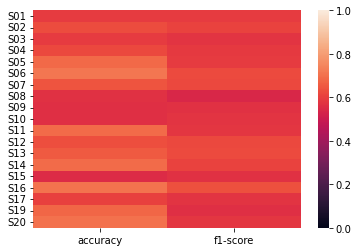

     class0 f1-score  class1 f1-score
S01         0.700000         0.352941
S02         0.740741         0.322581
S03         0.720930         0.234043
S04         0.750877         0.202247
S05         0.811594         0.071429
S06         0.829932         0.107143
S07         0.756554         0.315789
S08         0.705882         0.183673
S09         0.687023         0.280702
S10         0.658333         0.397059
S11         0.815603         0.000000
S12         0.743083         0.343434
S13         0.770370         0.295455
S14         0.810811         0.151515
S15         0.649573         0.378788
S16         0.818792         0.205882
S17         0.733871         0.214286
S19         0.807818         0.032787
S20         0.822368         0.035714


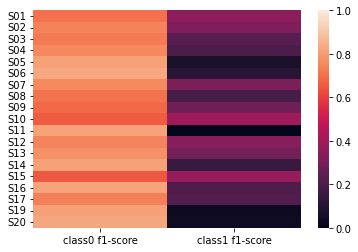

In [11]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)
